# Advanced Losses

This notebook covers more advanced losses and loss compositions, beyond the simple case of optimizing for a single loss or adding two losses together.

We go over how to optimize for a diversity-based loss and perform aligned interpolation, and show how to reproduce examples found in the Lucid library.

The examples here will be based on the GoogLeNet model, but they work equally well for `torchvision` models! Just remember to add the normalization transformation: `torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])` (See `GettingStarted_OptimViz` for more examples.)

## Diversity Loss

Neurons are often polysemantic, which means that a single neuron may be activated by several different features. With visualization via optimization, we may have no control over which feature we are optimizing for. The resulting visualization might contain a single feature or a mixture of different features.

To remedy this, the authors of the original Lucid library came up with a Diversity objective, which is also explored in the [Feature Visualization](https://distill.pub/2017/feature-visualization/#diversity) article. The main idea behind the Diversity objective is to minimize pairwise cosine similarities between the Gram matrix representations of each image in a batch. This is similar to the style similarity concept from [style transfer](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf).

The `optim.captum` library also contains the similar `Diversity` loss which can be used in the same fashion, to help tease out different features that activate a single neuron.

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision

import captum.optim as opt
from captum.optim.models import googlenet, InceptionV1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = googlenet(pretrained=True).to(device)

In [2]:
# Helper functions for visualizations
def visualize(model: torch.nn.Module, image: opt.images.ImageParameterization, loss_fn: opt.loss.Loss) -> None:
    obj = opt.InputOptimization(model, loss_fn, image)
    history = obj.optimize()
    image().show(figsize=(12, 10))

This neuron seems to be activated by different types of balls from different sports.

  0%|          | 0/512 [00:00<?, ? step/s]

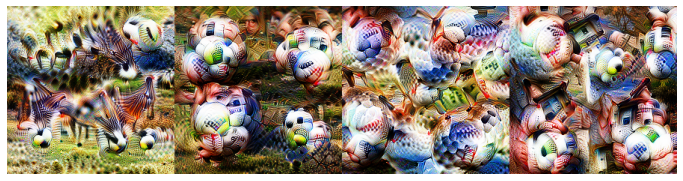

In [3]:
image = opt.images.NaturalImage((224, 224), batch=4).to(device)
loss_fn = sum([
    opt.loss.ChannelActivation(model.mixed5a, 9),
    1e2*opt.loss.Diversity(model.mixed5a),
])
visualize(model, image, loss_fn)

Activated by different types of curves.

  0%|          | 0/512 [00:00<?, ? step/s]

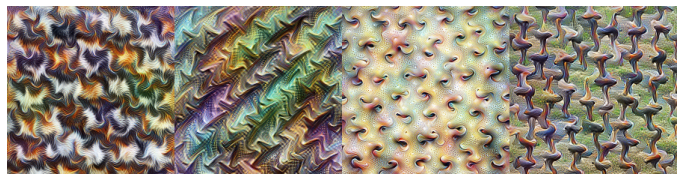

In [4]:
image = opt.images.NaturalImage((224, 224), batch=4).to(device)
loss_fn = sum([
    opt.loss.ChannelActivation(model.mixed4a, 97),
    1e3*opt.loss.Diversity(model.mixed4a),
])
visualize(model, image, loss_fn)

This neuron is activated by a brown fur-like texture from different directions.

  0%|          | 0/512 [00:00<?, ? step/s]

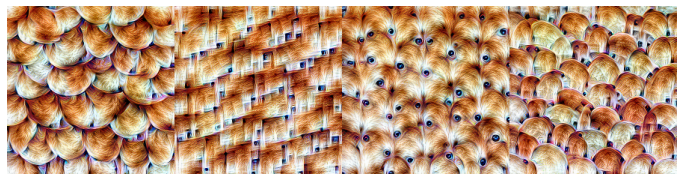

In [5]:
image = opt.images.NaturalImage((224, 224), batch=4).to(device)
loss_fn = sum([
    opt.loss.ChannelActivation(model.mixed4a, 143),
    1e2*opt.loss.Diversity(model.mixed4a),
])
visualize(model, image, loss_fn)

A neuron can also be activated by very different features, such as cats versus cars.

  0%|          | 0/512 [00:00<?, ? step/s]

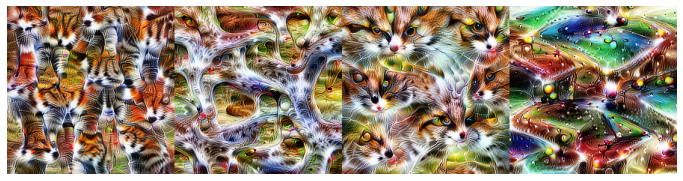

In [6]:
image = opt.images.NaturalImage((224, 224), batch=4).to(device)
loss_fn = sum([
    opt.loss.ChannelActivation(model.mixed4e, 55),
    1e2*opt.loss.Diversity(model.mixed4e),
])
visualize(model, image, loss_fn)

## Interpolation

The [Feature Visualization](https://distill.pub/2017/feature-visualization/#interaction) article also demonstrated interpolation between neurons with the Lucid library. This notebook shows how the same visualizations can be obtained with `captum.optim`. In particular, we are trying to achieve **aligned** interpolations, where the interpolated images have spatially aligned features.

Just like in Lucid, we do this via two loss functions. The first is `ActivationInterpolation`, which is simply a helper function that interpolates between two neurons for each image in a batch, similar to how we sum up neurons in the CompositeLoss notebook. The second loss function is `Alignment`, which is a L2 penalty between consecutive images in the batch, which encourages visual similarity between the images.

  0%|          | 0/512 [00:00<?, ? step/s]

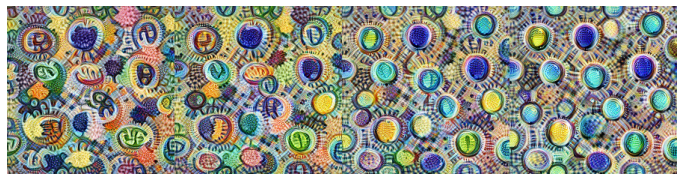

In [7]:
# Interpolating from "artsy" neuron to "gemstones" neuron
# Notice how the circular blobs in the first image transform into "gems" in the last image
# while remaining in the same place.
image = opt.images.NaturalImage((224, 224), batch=4).to(device)
loss_fn = sum([
    opt.loss.ActivationInterpolation(model.mixed4a, 476, model.mixed4a, 465),
    1e-1 * opt.loss.Alignment(model.mixed4a, 5.0)
])
visualize(model, image, loss_fn)

  0%|          | 0/512 [00:00<?, ? step/s]

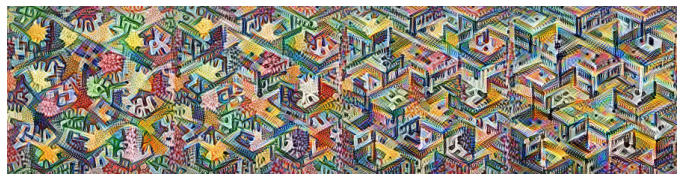

In [8]:
# Interpolating from "artsy" neuron to "buildings" neuron
image = opt.images.NaturalImage((224, 224), batch=4).to(device)
loss_fn = sum([
    opt.loss.ActivationInterpolation(model.mixed4a, 476, model.mixed4a, 455),
    1e-1 * opt.loss.Alignment(model.mixed4a, 5.0)
])
visualize(model, image, loss_fn)

  0%|          | 0/512 [00:00<?, ? step/s]

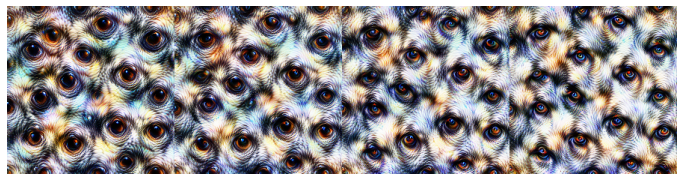

In [9]:
# Interpolating between different eye shapes
image = opt.images.NaturalImage((224, 224), batch=4).to(device)
loss_fn = sum([
    opt.loss.ActivationInterpolation(model.mixed4a, 460, model.mixed4a, 501),
    1e-1 * opt.loss.Alignment(model.mixed4a, 5.0)
])
visualize(model, image, loss_fn)